# How to read and analyse output from FOCI-OpenIFS with FOCI Tools

In [1]:
# Load the usual suspects
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 

## Load FOCI Tools

Note: If you modify focitools you will need to restart your kernel! 

In [2]:
# Need to append the focitools path to the pythonpath
import sys
sys.path.append('/Users/jkjellsson/focitools/')

In [3]:
import focitools 

## Configure Dask

In [4]:
from dask.distributed import Client, LocalCluster, wait

In [5]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61805,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:61826,Total threads: 2
Dashboard: http://127.0.0.1:61830/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:61808,


## Specify what to read

In [7]:
# Where is the data located? 
# This is usually some directory named esm-experiments in the work or scratch directory
esmdir = '/Users/jkjellsson/data/esm-experiments/'

# List of all experiment IDs
exps = ['FOCI_GJK029']

# List of the experiment names (this is just to label plots etc)
names = ['FOCI-OpenIFS-piControl']

# What times to read
times = [slice('1850-01-01','1860-01-01')]

## Read mesh information

In [8]:
ds = xr.open_dataset('%s/FOCI_GJK029/outdata/nemo/mesh_mask.nc' % (esmdir,))
lsm = ds['tmask'].isel(t=0).isel(z=0)
areacello = (ds['e1t'] * ds['e2t']).isel(t=0)
volcello = (ds['e1t'] * ds['e2t'] * ds['e3t_0']).isel(t=0).rename({'z':'deptht'})

## Read monthly OpenIFS data

ECHAM data is split into `ATM` and `BOT` files. 
* `ATM` contain 3D fields. 
* `BOT` contain 2D fields (this is the default to read)

OpenIFS data is split into `regular_sfc`, `regular_pl`, and `reduced_sfc`. 
* `regular_sfc` (2D fields, regular grid). Default to read
* `regular_pl` (3D fields, regular grid). 
* `reduced_sfc` (2D fields, native reduced Gaussian grid). 

Some OpenIFS may also include `regular_pv` (PV levels) and `regular_theta` (pot. temp. levels). 

In [ ]:
# read_openifs, read_echam, or read_nemo will read data from a multi-file dataset,r o m   a  all files into one data set (see open_mfdataset in xarray) in parallel.

ds_pl_1m_all = focitools.read_openifs(exps, times, esmdir, freq='1m', grid='regular_pl')

In [8]:
# If no freq or grid is specified, we will read monthly 2D fields
ds_sfc_1m_all = focitools.read_openifs(exps, times, esmdir)

/Users/jkjellsson/data/esm-experiments//FOCI_GJK029/outdata/oifs/FOCI_GJK029*1m*regular_sfc.nc


In [9]:
# Result is a list of all datasets. Let's look at the first element. 
ds_sfc_1m_all[0]

<xarray.Dataset>
Dimensions:               (lat: 96, lon: 192, time: 120, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    time_centered         (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) object 1850-01-16 12:00:00 ... 1859-12-16 12...
Dimensions without coordinates: axis_nbounds
Data variables: (12/46)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    es                    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    tclw                  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    ...                    ...
    swvl1                 (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    swvl2                 (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    swvl3                 (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    swvl4                 (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    sro                   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
    ssro                  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
Attributes:
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2023-Feb-19 13:41:02 GMT
    uuid:         3b3166db-6c1a-4d78-ba3e-27bee07b9dfe
    history:      Mon Feb 20 11:29:14 2023: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

## Read monthly NEMO data

NEMO data is given on the native Arakawa C-grid where velocities are defined on the grid cell faces while tracers are defined in the cell mid-point. 
The output thus comprises
* `grid_T` - Data from the T-points, e.g. temperature, salinity, MLD, SSH, etc
* `grid_U` - Data from the U-points. Zonal velocity, zonal wind stress, etc
* `grid_V` - Data from the V-points. Meridional velocity, meridional wind stress etc.
* `grid_W` - Data from the W-points. Vertical velocity, diffusivities etc.
* `ptrc_T` - Passive tracers at T-points, e.g. age tracer.
* `icemod` - Output from the ice model, at T points. 

In [11]:
# Without keyword arguments, we will get monthly grid_T data
ds_t_1m_all = focitools.read_nemo(exps, times, esmdir)

/Users/jkjellsson/data/esm-experiments//FOCI_GJK029/outdata/nemo/FOCI_GJK029*1m*grid_T.nc


In [12]:
# Now we specify that we want ice data monthly
ds_ice_1m_all = focitools.read_nemo(exps, times, esmdir, grid='icemod', freq='1m')

/Users/jkjellsson/data/esm-experiments//FOCI_GJK029/outdata/nemo/FOCI_GJK029*1m*icemod.nc


## Compute global-mean surface air temperature

In [13]:
# List for results
gmst_all = []

# Loop over each experiment 
for i, ds in enumerate( ds_sfc_1m_all ):

    # 2m air temp (tas in CMIP) is named 2t in OpenIFS
    tas = ds['2t']

    # Compute area-weighted global mean 
    gmst = focitools.area_mean(tas)

    # Xarray normally does lazy reading, so when you write e.g. 
    # tas.mean() it does not actually do any computing. 
    # By saying .compute() we force it to do all calculations now. 
    # So this command might take a while...
    gmst_all.append(gmst.compute())

## Plot global-mean surface air temperature

Text(0.5, 1.0, 'Global-mean surface air temperature')

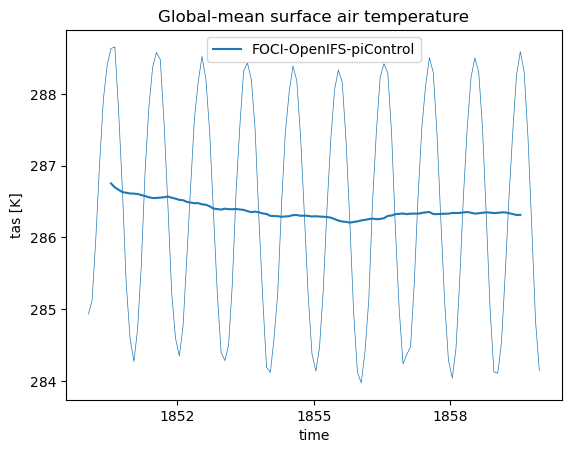

In [14]:
# Set up figure
fig1, ax1 = plt.subplots(1,1)

# Loop over all experiments 
for i, (gmst, name) in enumerate( zip(gmst_all, names) ):

    # Draw monthly data as thin line
    p, = gmst.plot(ax=ax1, lw=0.5)

    # Draw annual mean as full line
    # Make sure its the same colour as the other line
    gmst.rolling(time=12, center=True).mean().plot(ax=ax1, label=name, c=p.get_color())

# Draw legend, set labels
ax1.legend()
ax1.set_ylabel('tas [K]')
ax1.set_title('Global-mean surface air temperature')

## Compute global mean SST 

In [34]:
# Where to store data
glomean_sst_all = []

# Loop over all experiments
for ds in ds_t_1m_all:
    
    # Area-weighted global mean in NEMO
    mean_sst = focitools.area_mean_nemo(ds['sosstsst'], lsm, areacello)

    # As for GMST above, we call .compute() to force calculations to happen now
    # so that when we plot the plot renders instantly. 
    glomean_sst_all.append(mean_sst.compute())

Task exception was never retrieved
future: <Task finished name='Task-770986' coro=<Client._gather.<locals>.wait() done, defined at /Users/jkjellsson/miniforge3/envs/py3_std/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/jkjellsson/miniforge3/envs/py3_std/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-771054' coro=<Client._gather.<locals>.wait() done, defined at /Users/jkjellsson/miniforge3/envs/py3_std/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/jkjellsson/miniforge3/envs/py3_std/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-771118' coro=<Client.

KeyboardInterrupt: 

## Compute sea ice area and volume

Sea ice area (SIA) is the product of ice concentration and cell area. We sum for Northern and Southern Hemisphere separately. 
SIA is total area covered by sea ice. Sea-ice extent (SIE) is total area where ice concentration > 15%. 

For sea-ice volume (SIV) we need to multiply cell average thickness by cell area. Take care NOT to use thickness averaged over only the sea-ice covered part! 

In [24]:
# Store results
ds_area_all = []

# Loop over experiments
for ds in ds_ice_1m_all:

    # Compute sea-ice area and extent for Arctic and Antarctic
    # By default, sea-ice concentration is assumed to have the name ileadfra
    # and latitude nav_lat
    ds_area = focitools.seaice_areas(ds, areacello, lsm)

    # Compute results now and save
    ds_area_all.append(ds_area.compute())

In [27]:
# Repeat for volume
ds_vol_all = []

# Loop over experiments
for ds in ds_ice_1m_all:

    # Compute sea-ice volume (total volume of sea ice) and mean thickness where fraction > 15%
    # By default, sea-ice concentration is assumed to have the name ileadfra, thickness is iicethic, 
    # and latitude nav_lat
    ds_vol = focitools.ice_volumes(ds, areacello, lsm)

    # Compute results now and save
    ds_vol_all.append(ds_vol.compute())

/Users/jkjellsson/miniforge3/envs/py3_std/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 12.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


## Plot sea-ice area and extent

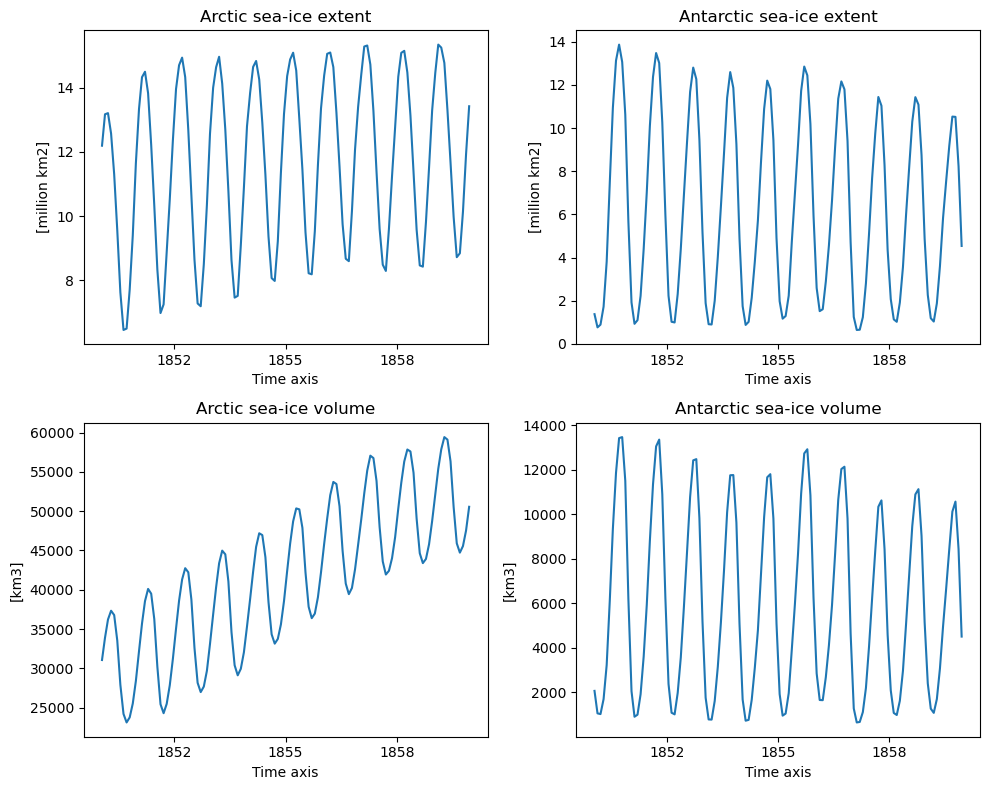

In [32]:
fig1, axs1 = plt.subplots(2, 2, figsize=(10,8))

for i, (ds_area, ds_vol, name) in enumerate( zip(ds_area_all, ds_vol_all, names) ):

    # ar_sie - Arctic SIE
    # ar_sia - Arctic SIA
    # an_sie - Antarctic SIE
    # an_sia - Antarctic SIA
    p, = ds_area['ar_sie'].plot(ax=axs1[0,0], label=name)
    ds_area['an_sie'].plot(ax=axs1[0,1], color=p.get_color()) 

    # ar_siv - Arctic SIV
    # an_siv - Antarctic SIV
    ds_vol['ar_siv'].plot(ax=axs1[1,0], color=p.get_color())
    ds_vol['an_siv'].plot(ax=axs1[1,1], color=p.get_color())
    
# set titles
axs1[0,0].set_title('Arctic sea-ice extent')
axs1[0,1].set_title('Antarctic sea-ice extent')
axs1[1,0].set_title('Arctic sea-ice volume')
axs1[1,1].set_title('Antarctic sea-ice volume')

for ax in axs1[0,:]:
    # data has been scaled to million km2
    ax.set_ylabel('[million km2]')

for ax in axs1[1,:]:
    # data has been scaled to km3
    ax.set_ylabel('[km3]')

fig1.tight_layout()